In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,StratifiedKFold, GridSearchCV
from sklearn import metrics, set_config#, cross_validation
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer#,make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
import numpy as np
from time import time
import xgboost as xgb
from matplotlib.pylab import rcParams
%matplotlib inline
set_config(display='diagram')
pd.set_option('max_columns',70)
pd.set_option('max_rows',70)

In [2]:
df2 = pd.read_csv(r'.csv')
df2['Month'] = df2['Month'].map({"Feb":2
                               , "Mar":3
                               , "May":5
                               , "June":6
                               , "Jul":7
                               , "Aug":8
                               , "Sep":9
                               , "Oct":10
                               , "Nov":11
                               , "Dec":12})

In [3]:
oe = OrdinalEncoder(categories=[["2", "3", "5", "6", "7", "8", "9", "10", "11", "12"]])
df2['Month'] = oe.fit_transform(df2[['Month']])

In [4]:
ohe = OneHotEncoder(sparse= False,handle_unknown = 'ignore')
display(ohe.fit_transform(df2[['Weekend', 'VisitorType', 'OperatingSystems','Browser','Region','TrafficType']]))
feature_names = ohe.get_feature_names(['Weekend', 'VisitorType', 'OperatingSystems','Browser','Region','TrafficType'])
display(feature_names[:10])
df_ohe = pd.DataFrame(ohe.fit_transform(df2[['Weekend', 'VisitorType', 'OperatingSystems','Browser','Region','TrafficType']]), columns = feature_names)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

array(['Weekend_False', 'Weekend_True', 'VisitorType_New_Visitor',
       'VisitorType_Other', 'VisitorType_Returning_Visitor',
       'OperatingSystems_1', 'OperatingSystems_2', 'OperatingSystems_3',
       'OperatingSystems_4', 'OperatingSystems_5'], dtype=object)

In [5]:
df_good = pd.concat([df2.drop(columns = ['Weekend', 'VisitorType', 'OperatingSystems','Browser','Region','TrafficType']), df_ohe], axis = 1)
X = df_good.drop(['Revenue'], axis='columns')
y = df_good.Revenue

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42, stratify = y)
display(X_train.shape, y_train.shape)
display(y_train.value_counts(normalize=True))
y_test.value_counts(normalize=True)

(8631, 66)

(8631,)

False    0.845209
True     0.154791
Name: Revenue, dtype: float64

False    0.845364
True     0.154636
Name: Revenue, dtype: float64

In [7]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', missing = None, seed = 42)
clf_xgb.fit(X_train,
           y_train,
           verbose = True,
           early_stopping_rounds = 10,
           eval_metric = 'aucpr',
           eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.67630
[1]	validation_0-aucpr:0.69589


c:\users\rex.wong\appdata\local\programs\python\python37\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-aucpr:0.70450
[3]	validation_0-aucpr:0.70846
[4]	validation_0-aucpr:0.71799
[5]	validation_0-aucpr:0.71662
[6]	validation_0-aucpr:0.72164
[7]	validation_0-aucpr:0.72040
[8]	validation_0-aucpr:0.72121
[9]	validation_0-aucpr:0.72610
[10]	validation_0-aucpr:0.72487
[11]	validation_0-aucpr:0.72554
[12]	validation_0-aucpr:0.72202
[13]	validation_0-aucpr:0.72278
[14]	validation_0-aucpr:0.72355
[15]	validation_0-aucpr:0.72411
[16]	validation_0-aucpr:0.72190
[17]	validation_0-aucpr:0.72167
[18]	validation_0-aucpr:0.71983


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Training accuracy is  0.936
Testing accuracy is  0.900
              precision    recall  f1-score   support

       False       0.93      0.96      0.94      3127
        True       0.71      0.59      0.65       572

    accuracy                           0.90      3699
   macro avg       0.82      0.78      0.80      3699
weighted avg       0.89      0.90      0.90      3699



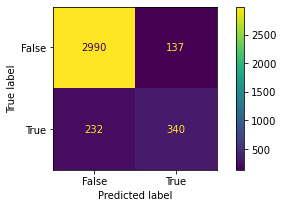

In [8]:
rcParams['figure.figsize'] = [7,3]
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format = 'd')

y_train_predict = clf_xgb.predict(X_train)
y_predict = clf_xgb.predict(X_test)

print('Training accuracy is ',"{:.3f}".format(metrics.accuracy_score(y_train, y_train_predict)))
print('Testing accuracy is ',"{:.3f}".format(metrics.accuracy_score(y_test, y_predict)))
print(metrics.classification_report(y_test, y_predict))

# Adjusting scale_pos_weight to 5 after a few attempts

In [9]:
clf_xgb_ad = xgb.XGBClassifier(objective = 'binary:logistic', missing = None, seed = 42, scale_pos_weight = 5)
clf_xgb_ad.fit(X_train,
           y_train,
           verbose = True,
           early_stopping_rounds = 10,
           eval_metric = 'aucpr',
           eval_set = [(X_test, y_test)])

[0]	validation_0-aucpr:0.66352
[1]	validation_0-aucpr:0.67670
[2]	validation_0-aucpr:0.68409
[3]	validation_0-aucpr:0.69018
[4]	validation_0-aucpr:0.70696
[5]	validation_0-aucpr:0.71006
[6]	validation_0-aucpr:0.71535
[7]	validation_0-aucpr:0.71467
[8]	validation_0-aucpr:0.72040
[9]	validation_0-aucpr:0.71613
[10]	validation_0-aucpr:0.71333
[11]	validation_0-aucpr:0.71436
[12]	validation_0-aucpr:0.71563
[13]	validation_0-aucpr:0.71821
[14]	validation_0-aucpr:0.71720
[15]	validation_0-aucpr:0.71695
[16]	validation_0-aucpr:0.71686
[17]	validation_0-aucpr:0.71616
[18]	validation_0-aucpr:0.71875


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Training accuracy is  0.897
Testing accuracy is  0.869
              precision    recall  f1-score   support

       False       0.96      0.88      0.92      3127
        True       0.55      0.79      0.65       572

    accuracy                           0.87      3699
   macro avg       0.76      0.84      0.78      3699
weighted avg       0.90      0.87      0.88      3699



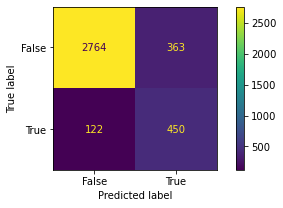

In [10]:
plot_confusion_matrix(clf_xgb_ad, X_test, y_test, values_format = 'd')

y_train_predict_ad = clf_xgb_ad.predict(X_train)
y_predict_ad = clf_xgb_ad.predict(X_test)

print('Training accuracy is ',"{:.3f}".format(metrics.accuracy_score(y_train, y_train_predict_ad)))
print('Testing accuracy is ',"{:.3f}".format(metrics.accuracy_score(y_test, y_predict_ad)))
print(metrics.classification_report(y_test, y_predict_ad))

# Hyperparameter Tuning

In [11]:
# 1st round of hyperparameters tuning
param_grid = {'max_depth': [3,4,5],
              'learning_rate': [0.1, 0.01, 0.05],
              'gamma': [0, 0.25, 1],
              'reg_lambda': [ 0,1,10],
#               'scale_pos_weight': [1,3,5]
             }

In [12]:
optimal_params = GridSearchCV(estimator = xgb.XGBClassifier (objective = 'binary:logistic',
                                                             seed = 42,
                                                             subsample = 0.9,
                                                             colsample_bytree = 0.5,
                                                            scale_pos_weight = 5),
                              param_grid = param_grid,
scoring = 'roc_auc',
verbose =3,
n_jobs = 10,
cv=3)

In [13]:
start = time()
optimal_params.fit(X_train, y_train
                   , early_stopping_rounds = 10
                   , eval_metric = 'auc', verbose = True,
                  eval_set = [(X_test, y_test)])

end = time()
print('Model fitting time:' , end - start)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   28.7s


[0]	validation_0-auc:0.87707
[1]	validation_0-auc:0.91018
[2]	validation_0-auc:0.91001
[3]	validation_0-auc:0.90020
[4]	validation_0-auc:0.90929
[5]	validation_0-auc:0.91171
[6]	validation_0-auc:0.91603
[7]	validation_0-auc:0.91631
[8]	validation_0-auc:0.91531
[9]	validation_0-auc:0.91495


[Parallel(n_jobs=10)]: Done 243 out of 243 | elapsed:   55.8s finished
c:\users\rex.wong\appdata\local\programs\python\python37\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-auc:0.91360
[11]	validation_0-auc:0.91648
[12]	validation_0-auc:0.91592
[13]	validation_0-auc:0.91554
[14]	validation_0-auc:0.91680
[15]	validation_0-auc:0.91666
[16]	validation_0-auc:0.91635
[17]	validation_0-auc:0.91550
[18]	validation_0-auc:0.91691
[19]	validation_0-auc:0.91849
[20]	validation_0-auc:0.91922
[21]	validation_0-auc:0.91866
[22]	validation_0-auc:0.91827
[23]	validation_0-auc:0.91811
[24]	validation_0-auc:0.91856
[25]	validation_0-auc:0.91994
[26]	validation_0-auc:0.92114
[27]	validation_0-auc:0.92171
[28]	validation_0-auc:0.92193
[29]	validation_0-auc:0.92154
[30]	validation_0-auc:0.92162
[31]	validation_0-auc:0.92279
[32]	validation_0-auc:0.92308
[33]	validation_0-auc:0.92326
[34]	validation_0-auc:0.92316
[35]	validation_0-auc:0.92362
[36]	validation_0-auc:0.92375
[37]	validation_0-auc:0.92402
[38]	validation_0-auc:0.92449
[39]	validation_0-auc:0.92432
[40]	validation_0-auc:0.92500
[41]	validation_0-auc:0.92499
[42]	validation_0-auc:0.92496
[43]	valid

In [14]:
display(optimal_params.best_score_)
optimal_params.best_params_

0.9337661137059983

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 1}

# 2nd round of hyperparameters tuning, trying a different learning_rate

In [15]:
param_grid2 = {'max_depth': [4],
              'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5, 1],
              'gamma': [0],
              'reg_lambda': [1],
             }

In [16]:
optimal_params2 = GridSearchCV(estimator = xgb.XGBClassifier (objective = 'binary:logistic',
                                                             seed = 42,
                                                             subsample = 0.9,
                                                             colsample_bytree = 0.5,
                                                             scale_pos_weight = 5),
                              param_grid = param_grid2,
scoring = 'roc_auc',
verbose =True,
n_jobs = 10,
cv=3)

In [17]:
start = time()
optimal_params2.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric = 'auc', verbose = True,
                  eval_set = [(X_test, y_test)])

end = time()
print('Model fitting time:' , end - start)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


[0]	validation_0-auc:0.87707
[1]	validation_0-auc:0.91018
[2]	validation_0-auc:0.91001
[3]	validation_0-auc:0.90020
[4]	validation_0-auc:0.90929
[5]	validation_0-auc:0.91171
[6]	validation_0-auc:0.91603
[7]	validation_0-auc:0.91631
[8]	validation_0-auc:0.91531
[9]	validation_0-auc:0.91495
[10]	validation_0-auc:0.91360
[11]	validation_0-auc:0.91648
[12]	validation_0-auc:0.91592


[Parallel(n_jobs=10)]: Done  18 out of  18 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  18 | elapsed:    2.8s finished
c:\users\rex.wong\appdata\local\programs\python\python37\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13]	validation_0-auc:0.91554
[14]	validation_0-auc:0.91680
[15]	validation_0-auc:0.91666
[16]	validation_0-auc:0.91635
[17]	validation_0-auc:0.91550
[18]	validation_0-auc:0.91691
[19]	validation_0-auc:0.91849
[20]	validation_0-auc:0.91922
[21]	validation_0-auc:0.91866
[22]	validation_0-auc:0.91827
[23]	validation_0-auc:0.91811
[24]	validation_0-auc:0.91856
[25]	validation_0-auc:0.91994
[26]	validation_0-auc:0.92114
[27]	validation_0-auc:0.92171
[28]	validation_0-auc:0.92193
[29]	validation_0-auc:0.92154
[30]	validation_0-auc:0.92162
[31]	validation_0-auc:0.92279
[32]	validation_0-auc:0.92308
[33]	validation_0-auc:0.92326
[34]	validation_0-auc:0.92316
[35]	validation_0-auc:0.92362
[36]	validation_0-auc:0.92375
[37]	validation_0-auc:0.92402
[38]	validation_0-auc:0.92449
[39]	validation_0-auc:0.92432
[40]	validation_0-auc:0.92500
[41]	validation_0-auc:0.92499
[42]	validation_0-auc:0.92496
[43]	validation_0-auc:0.92548
[44]	validation_0-auc:0.92552
[45]	validation_0-auc:0.92613
[46]	valid

In [18]:
display(optimal_params2.best_score_)
optimal_params2.best_params_

0.9337661137059983

{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 1}

#### After testing all possible combinations with CV, we should set gamma = 0.0, learn_rate = 0.1, max_depth = 4, reg_lambda = 1

In [19]:
clf_xgb2 = xgb.XGBClassifier(objective = 'binary:logistic'
                             , missing = None
                             , seed = 42
                             , gamma = 0
                             , learning_rate = 0.1
                             , max_depth = 4
                             , reg_lambda = 1
                             , scale_pos_weight = 5    # high proportion/ low proportion
                             , subsample = 0.9
                             , colsample_bytree = 0.5
                            )

clf_xgb2.fit(X_train,
           y_train,
           verbose = False,
           early_stopping_rounds = 10,
           eval_metric = 'auc',
           eval_set = [(X_test, y_test)])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

Training accuracy is  0.8896999188969992
Testing accuracy is  0.8664503919978372
              precision    recall  f1-score   support

       False       0.96      0.88      0.92      3127
        True       0.55      0.80      0.65       572

    accuracy                           0.87      3699
   macro avg       0.75      0.84      0.78      3699
weighted avg       0.90      0.87      0.88      3699



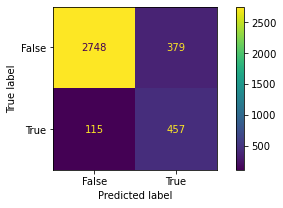

In [20]:
y_train_predict2 = clf_xgb2.predict(X_train)
y_predict2 = clf_xgb2.predict(X_test)
print('Training accuracy is ',metrics.accuracy_score(y_train, y_train_predict2))
print('Testing accuracy is ',metrics.accuracy_score(y_test, y_predict2))

print(metrics.classification_report(y_test, y_predict2))
plot_confusion_matrix(clf_xgb2, X_test, y_test, values_format = 'd')

## Feature Importance

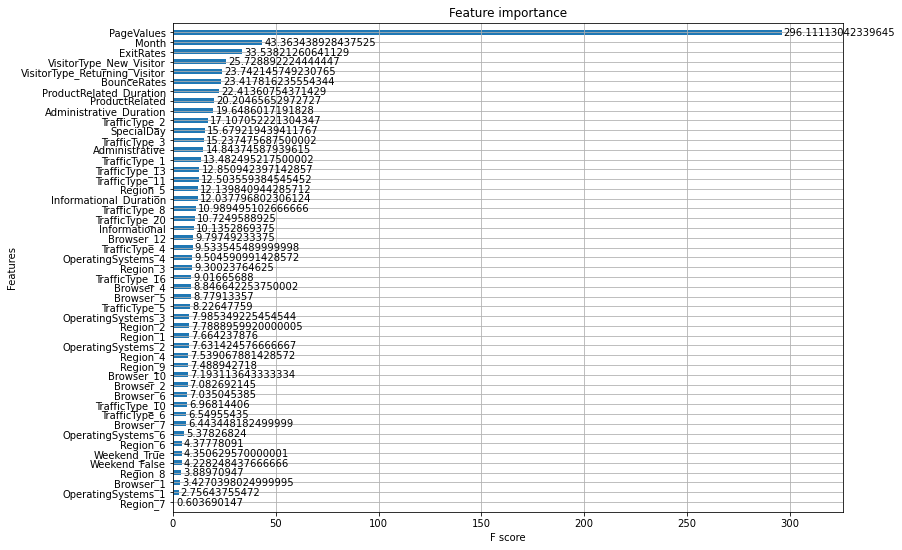

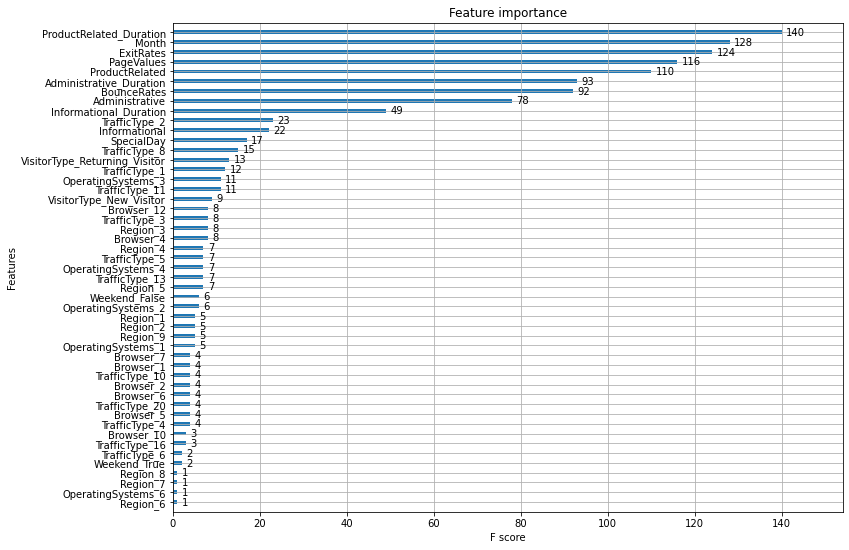

In [21]:
rcParams['figure.figsize'] = [12,9]
xgb.plot_importance(clf_xgb2, height = 0.5, importance_type = 'gain')
xgb.plot_importance(clf_xgb2, height = 0.4, importance_type = 'weight')